In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import sqlite3

# Symbol
symbol = 'BTCUSDT'

# Start and end time stamps
start_year = 2023
start_month = 1
start_day = 1

start_datetime = datetime.datetime(start_year, start_month, start_day)
start_timestamp = time.mktime(start_datetime.timetuple()) * 1000 # In milliseconds 
start_timestamp = int(start_timestamp)

end_year = 2024
end_month = 1
end_day = 1

end_datetime = datetime.datetime(end_year, end_month, end_day)
end_timestamp = time.mktime(end_datetime.timetuple()) * 1000 # In milliseconds 
end_timestamp = int(end_timestamp)

# Get data set. First I'll pull all the data at once, then refactor for a data source object
sql_check_spec = '''SELECT ticker_time, open_price, volume FROM spot_entry WHERE symbol = ? and ticker_time > ? and ticker_time < ?'''

connection = sqlite3.connect("../database/ticker_data.db")
with connection:
    cursor = connection.cursor()

sql_check_val = (symbol,) + (start_timestamp,) + (end_timestamp,)

cursor.execute(sql_check_spec, sql_check_val)
spot_data = cursor.fetchall()
spot_data = np.array(spot_data)


In [37]:
#
# n_momentum = np.array([1, 3,  10, 21, 50],  dtype=int) 
n_momentum = np.array([14],  dtype=int) 
s_window = n_momentum * 24 * 60

t = (spot_data[:,0] - spot_data[0,0]) / 1000/ 60 / 60 / 24
open_price = spot_data[:,1]
volume = spot_data[:,2]
n_points = len(t)


n_trades = 0
t_trade = np.array(t[s_window])


In [43]:
usd = 100
btc = 0
btc_hold = usd / open_price[s_window]

momentum_arr = np.array([[]])
usd_balance = np.array([])
btc_hold_arr = np.array([])
t_step = np.array([])
t_trade = np.array([])

for current_index in range(s_window[-1], n_points, 60):
	
	current_time = t[current_index]
	t_step = np.append(t_step, current_time)

	segment_start_idx = current_index - s_window
	current_price = open_price[current_index]
	delay_price = open_price[segment_start_idx]

	momentum = current_price - delay_price
	momentum_arr = np.vstack([momentum_arr, momentum]) if momentum_arr.size else momentum
	
	btc_hold_arr = np.append(btc_hold_arr, btc_hold * current_price)

	if btc:
		usd_balance = np.append(usd_balance, btc * current_price)
		if momentum < 0:
			usd = btc * current_price
			btc = 0
			t_trade = np.append(t_trade, current_time)
	else:
		usd_balance = np.append(usd_balance, usd)
		if momentum > 0: 
			btc = usd / current_price
			usd = 0
			t_trade = np.append(t_trade, current_time)



print(btc * current_price)
print(usd)



153.31283668197557
0


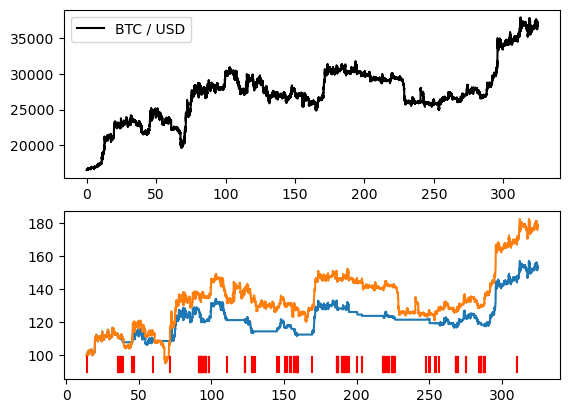

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t,open_price,color='black', label='BTC / USD')
ax1.legend()

ax2.plot(t_step, usd_balance, label='USD Balance')
ax2.plot(t_step, btc_hold_arr, label='Hold Balance')
ax2.legend()

trade_bars_x = np.vstack([t_trade, t_trade])
trade_bars_y = np.vstack([90 * np.ones_like(t_trade), 99 * np.ones_like(t_trade)])

ax2.plot(trade_bars_x,trade_bars_y, color='red')
plt.show()